In [199]:
# import required packages and utilities
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Vgg16 utils
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess 

# Resnet utils 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# utils to dump 
from pickle import dump
# import glob
import glob

In [2]:
# load image
image = load_img("/Users/varun/trunk/kumud/COURSES/EAI6010/Final_Project/images/iCard_021873_1_Daba_Ayehush_H.jpg")

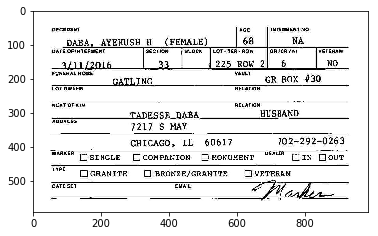

In [3]:
# plot how the image looks like
plt.imshow(image)

In [5]:
data_dir = "/Users/varun/trunk/kumud/COURSES/EAI6010/Final_Project/forms/"

In [25]:
X = []
Y = []
for img_path in glob.glob(data_dir+"*/*.jpg"):
    img = img_path.split("/")
    label = None
    if img[-2] == "Type-1 blocks":
        label = 1
    elif img[-2] == "Type-2 Empty":
        label = 2
    elif img[-2] == "Type-3 lines":
        label = 3
    elif img[-2] == "HandWritten":
        label = 0
    else:
        print("Unknown label type", img[-2])
    Y.append(label)
    X.append(img_to_array(load_img(img_path,target_size=(224, 224))))

In [26]:
print(len(Y),len(X))

120 120


In [27]:
Y[:10]

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

In [11]:
X[1].shape

(224, 224, 3)

## Image calssification


### Train Model

In [233]:
# Build first model
model1 = Sequential([
    Dense(64,input_shape = (224, 224, 3), activation='relu'),
    Dense(128, activation ='relu'),
    Flatten(),
    Dense(4, activation='softmax')])

In [234]:
model1.summary()

Model: "sequential_253"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_509 (Dense)            (None, 224, 224, 64)      256       
_________________________________________________________________
dense_510 (Dense)            (None, 224, 224, 128)     8320      
_________________________________________________________________
flatten_253 (Flatten)        (None, 6422528)           0         
_________________________________________________________________
dense_511 (Dense)            (None, 4)                 25690116  
Total params: 25,698,692
Trainable params: 25,698,692
Non-trainable params: 0
_________________________________________________________________


In [235]:
# compile model
model1.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [236]:
# splitting into train test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state = 123)

In [221]:
# inspect test labels contains all tyoes of forms
y_test

[0, 2, 2, 2, 1, 1, 2, 3, 1, 1, 1, 1, 0, 0, 1, 3, 2, 3, 2, 3, 1, 2, 3, 3]

In [222]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [237]:
# fitting our first model : Feedforward NN 
model1.fit(np.array(X_train), np.array(y_train_cat), epochs=10, batch_size=10,verbose =1)

Train on 96 samples
Epoch 1/10
96/96 [==============================] - 14s 147ms/sample - loss: 22179.8059 - accuracy: 0.4062
Epoch 2/10
96/96 [==============================] - 11s 118ms/sample - loss: 4182.6472 - accuracy: 0.5521
Epoch 3/10
96/96 [==============================] - 11s 112ms/sample - loss: 1191.6945 - accuracy: 0.8750
Epoch 4/10
96/96 [==============================] - 11s 111ms/sample - loss: 442.1157 - accuracy: 0.9167
Epoch 5/10
96/96 [==============================] - 10s 105ms/sample - loss: 31.7618 - accuracy: 0.9583
Epoch 6/10
96/96 [==============================] - 10s 105ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
96/96 [==============================] - 10s 107ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
96/96 [==============================] - 11s 111ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
96/96 [==============================] - 11s 111ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
96/96 [=====

In [238]:
# Accuracy on test data
score = model1.evaluate(np.array(X_test), np.array(y_test_cat), verbose=1)

24/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 1s 52ms/sample - loss: 670.9678 - accuracy: 0.8333


## Image classification using Transfer learning 
## Using pre-trained deep learning models as feature extractor

In [200]:
# function to extract features using pre-trained models
# extract features from each form in the directory

def extract_features_vgg(X):
    # load the model
    in_layer = Input(shape=(224, 224, 3))
    model = VGG16(include_top=False, input_tensor=in_layer)
    # extract features from each photo
    features = []
    for image in X:
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = vgg_preprocess(image)
        # get features
        feature = model.predict(image, verbose=0)
        # store feature
        features.append(feature)
    return features


def extract_features_resnet(X):
# load the model
    in_layer = Input(shape=(224, 224, 3))
    model = ResNet50(include_top=False, input_tensor=in_layer)
    # extract features from each photo
    features = []
    for image in X:
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the ResNet model
        image = resnet_preprocess(image)
        # get features
        feature = model.predict(image, verbose=0)
        # store feature
        features.append(feature)
    return features

In [201]:
# extracting features using VGG
X_vgg_features = extract_features_vgg(X)

In [120]:
# convert into categorical
y_cat = tf.keras.utils.to_categorical(Y)

In [ ]:
# save extracted features 
dict_to_dump = {"X":X_vgg_features, "Y": Y}
# save to file
dump(dict_to_dump, open('vgg_features.pkl', 'wb'))

In [45]:
# extracting features using VGG
X_resnet_features = extract_features_resnet(X)

In [202]:
#Ref: https://www.tensorflow.org/guide/keras/overview
# build our own model
def build_model(hidden_size = 128):
    # build a feed forward NN 
    import tensorflow.keras as keras

    fnn_model = keras.Sequential()
    # Add a densely-connected layer 
    fnn_model.add(keras.layers.Flatten())
    fnn_model.add(keras.layers.Dense(hidden_size, activation='relu'))
    fnn_model.add(keras.layers.Dropout(0.2))
    # Add a softmax layer with 4 output units:
    fnn_model.add(keras.layers.Dense(4, activation='softmax'))

    fnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return fnn_model

In [206]:
# performing k-fold cross-validation
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=123)
cvscores_vgg = []
for train, test in kfold.split(X, Y):
    fnn_model = build_model(hidden_size=128)
    fnn_model.fit(np.array(X_vgg_features)[train], y_cat[train] , epochs=10, batch_size=128,verbose =0)
    score = fnn_model.evaluate(np.array(X_vgg_features)[test],y_cat[test],verbose=0)
    cvscores_vgg.append(score[1])

In [207]:
# print 6 fold cross validation acccuracy 
for i,score in enumerate(cvscores_vgg):
    print("The accuracy for Vgg fold {} is {:.2f}".format(i+1,score))

The accuracy for Vgg fold 1 is 0.95
The accuracy for Vgg fold 2 is 0.95
The accuracy for Vgg fold 3 is 0.95
The accuracy for Vgg fold 4 is 0.95
The accuracy for Vgg fold 5 is 1.00
The accuracy for Vgg fold 6 is 0.95


In [208]:
# taking average of accuracy of 6 fold
print("The average accuracy on VGG 6-fold cross validation is {:.2f} with standard deviation {:.2f}"\
      .format(np.mean(cvscores_vgg),np.std(cvscores_vgg)))

The average accuracy on VGG 6-fold cross validation is 0.96 with standard deviation 0.02


### Classifier using ResNet50 extracted features

In [210]:
cvscores_resnet = []
for train, test in kfold.split(X, Y):
    fnn_model = build_model(hidden_size=256)
    fnn_model.fit(np.array(X_resnet_features)[train], y_cat[train] , epochs=10, batch_size=32,verbose =0)
    score = fnn_model.evaluate(np.array(X_resnet_features)[test],y_cat[test],verbose=0)
    cvscores_resnet.append(score[1])

In [212]:
# print 6 fold cross validation acccuracy for Resnet50
for i,score in enumerate(cvscores_resnet):
    print("The accuracy for Resnet fold {} is {:.2f}".format(i+1,score))

The accuracy for Resnet fold 1 is 1.00
The accuracy for Resnet fold 2 is 1.00
The accuracy for Resnet fold 3 is 0.95
The accuracy for Resnet fold 4 is 0.95
The accuracy for Resnet fold 5 is 0.95
The accuracy for Resnet fold 6 is 0.95


In [213]:
# taking average of accuracy of k fold cv
print("The average accuracy on 6-fold cross validation for Resnet is {:.2f} with standard deviation {:.2f}"\
      .format(np.mean(cvscores_resnet),np.std(cvscores_resnet)))

The average accuracy on 6-fold cross validation for Resnet is 0.97 with standard deviation 0.02


In [174]:
cvscores_resnet

[1.0, 0.95238096, 0.95, 0.94736844, 0.94736844, 1.0]

In [214]:
cvscores_vgg

[0.95454544, 0.95238096, 0.95, 0.94736844, 1.0, 0.94736844]